In [16]:
import glob
import re
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import easse.sari
import easse.bleu
import easse.fkgl
import dataset_utils

In [2]:
parameter_names = ["timestamp", "algorithm", "type", "set", "dc", "ilt", "i", "n"]

In [3]:
full_dataset_only = True

In [4]:
def get_latest_run_names(full_dataset_only=False):
    with open("latest_run_names.json", encoding="utf8") as file:
        run_names = json.load(file)

    if full_dataset_only:
        # Only keeps runs with n=None (full dataset)
        run_names = [run_name for run_name in run_names if re.search(r"_n=None", run_name) is not None]

    return run_names

In [5]:
latest_run_names = get_latest_run_names(full_dataset_only=full_dataset_only)

In [6]:
def extract_parameters_from_file_names(parameter_names, file_names):
    extracted_parameters = np.array([re.search(r"timestamp=([\d\-_.]+)_algorithm=(\w+)_type=(abstract|sentence)_set=(train|test)_dc=([\w\-_]+)_ilt=([\w\-_]+)_i=(\d+|None)_n=(\d+|None)", file).groups() for file in file_names])
    extracted_parameter_df = pd.DataFrame(extracted_parameters, columns=parameter_names)
    return extracted_parameter_df # .T

def drop_single_value_columns(data_frame):
    common_column_values = []
    data_frame_copy = data_frame.copy()

    for column_name, column_series in data_frame.items():
        unique_column_values = set(column_series)
        if len(unique_column_values) == 1:
            common_column_value = unique_column_values.pop()
            common_column_values.append((column_name, common_column_value))

            data_frame_copy.drop(columns=[column_name], inplace=True)

    return data_frame_copy, common_column_values

def convert_row_to_name(file_parameter_row, ignored_columns=["timestamp"]):
    name_parts = []
    for column_name in file_parameter_row.keys():
        if column_name not in ignored_columns:
            value = file_parameter_row[column_name]
            name_parts.append(f"{column_name}={value}")
    
    return ", ".join(name_parts)

## Automatic metrics

#### Iteration graphs – each passage

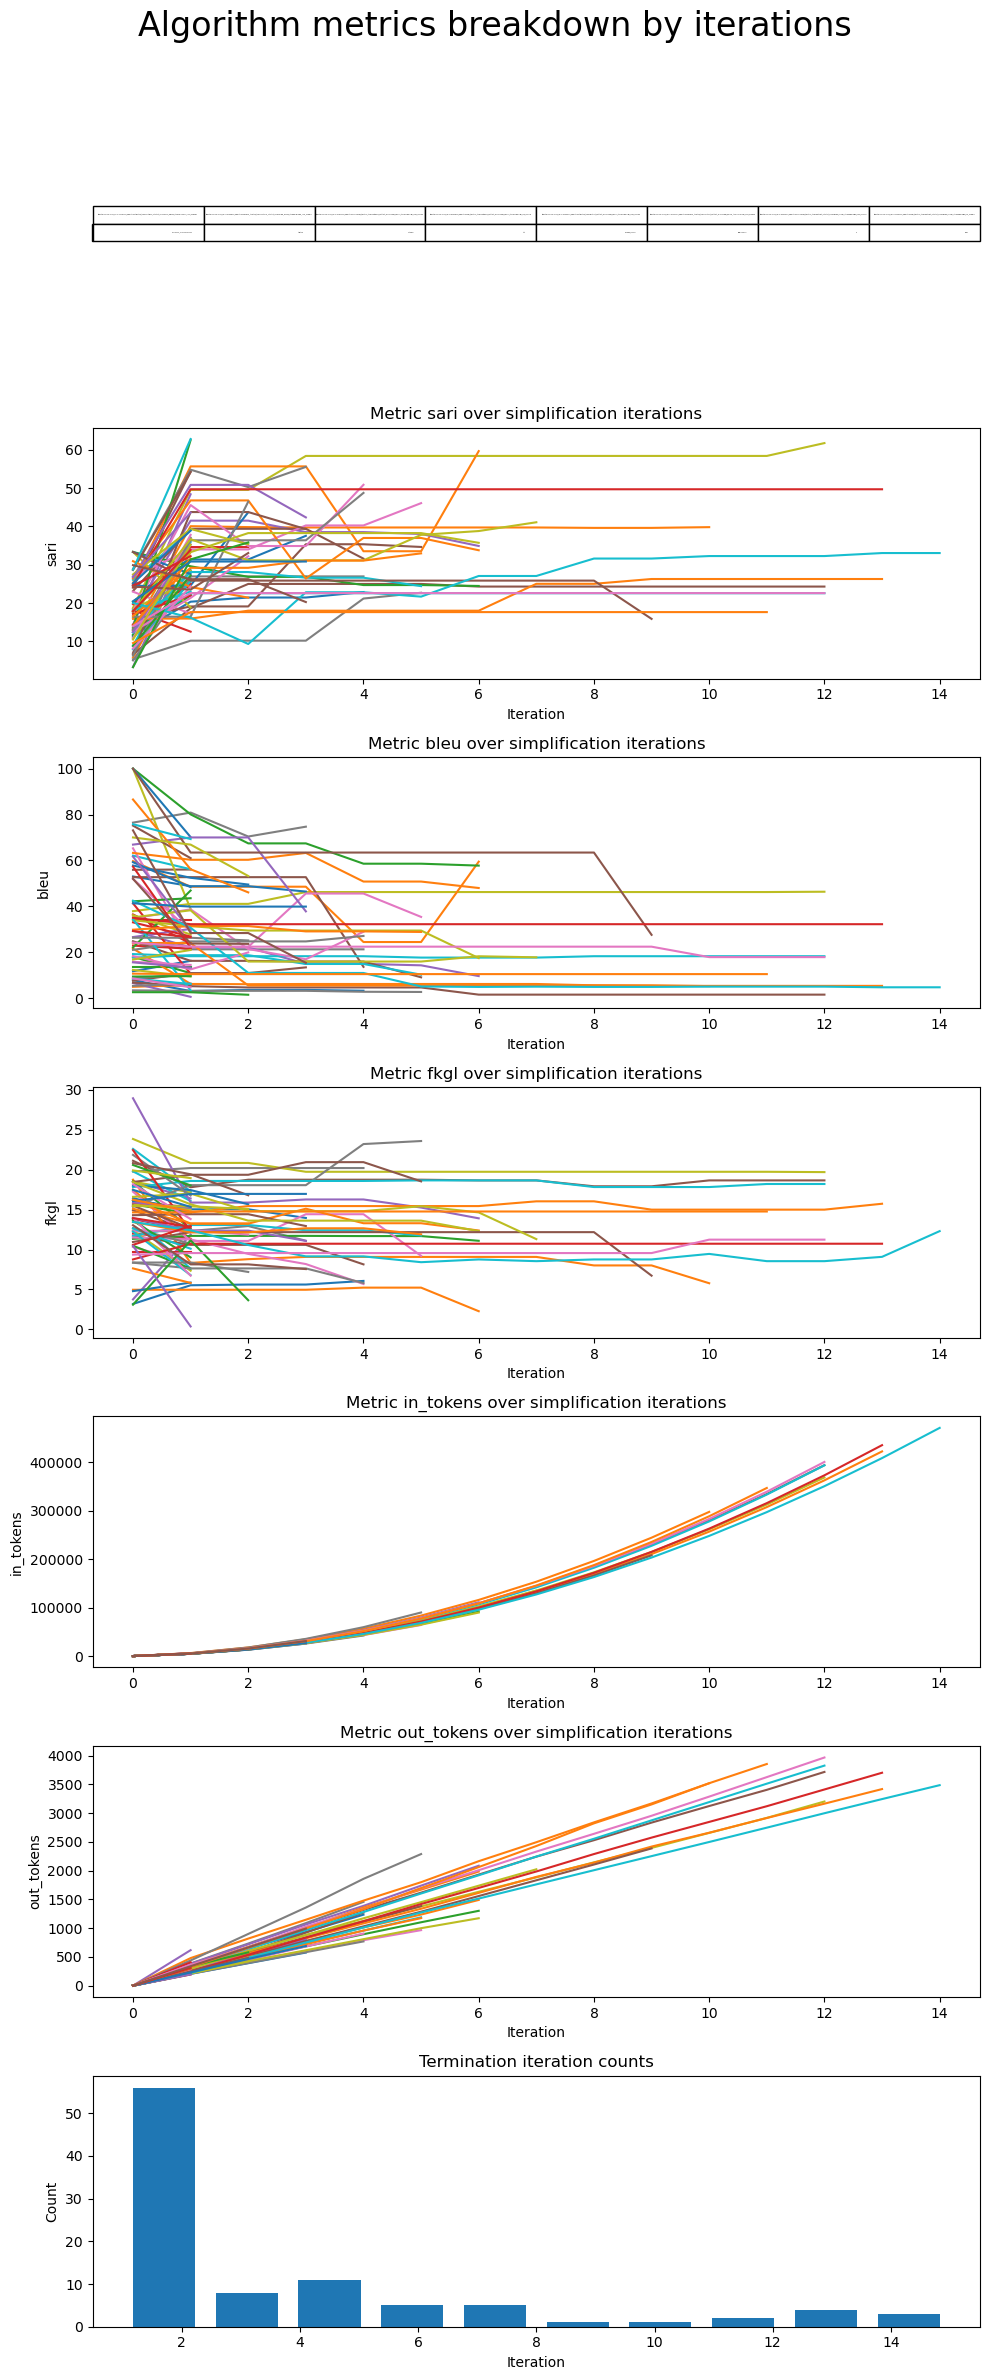

<Figure size 640x480 with 0 Axes>

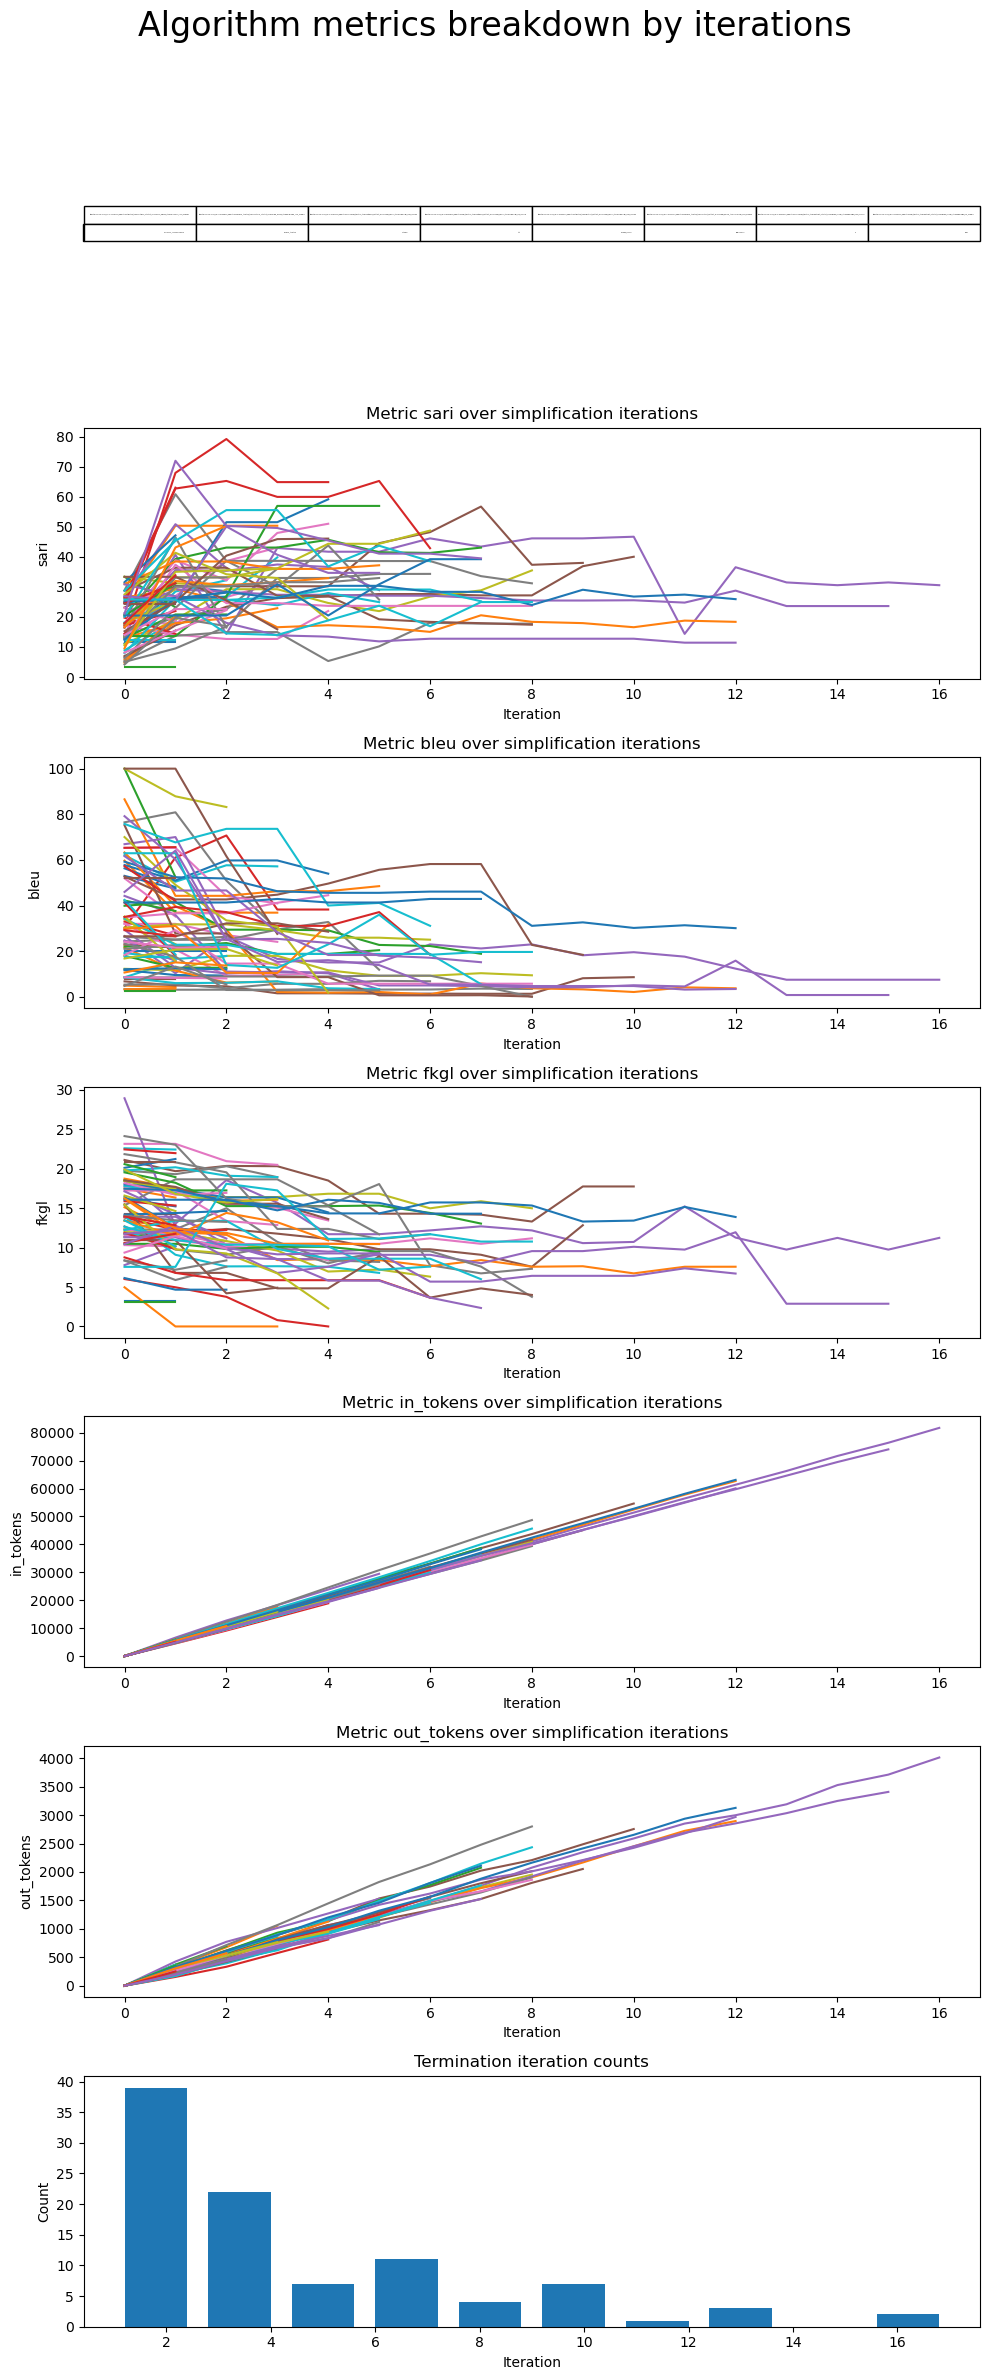

<Figure size 640x480 with 0 Axes>

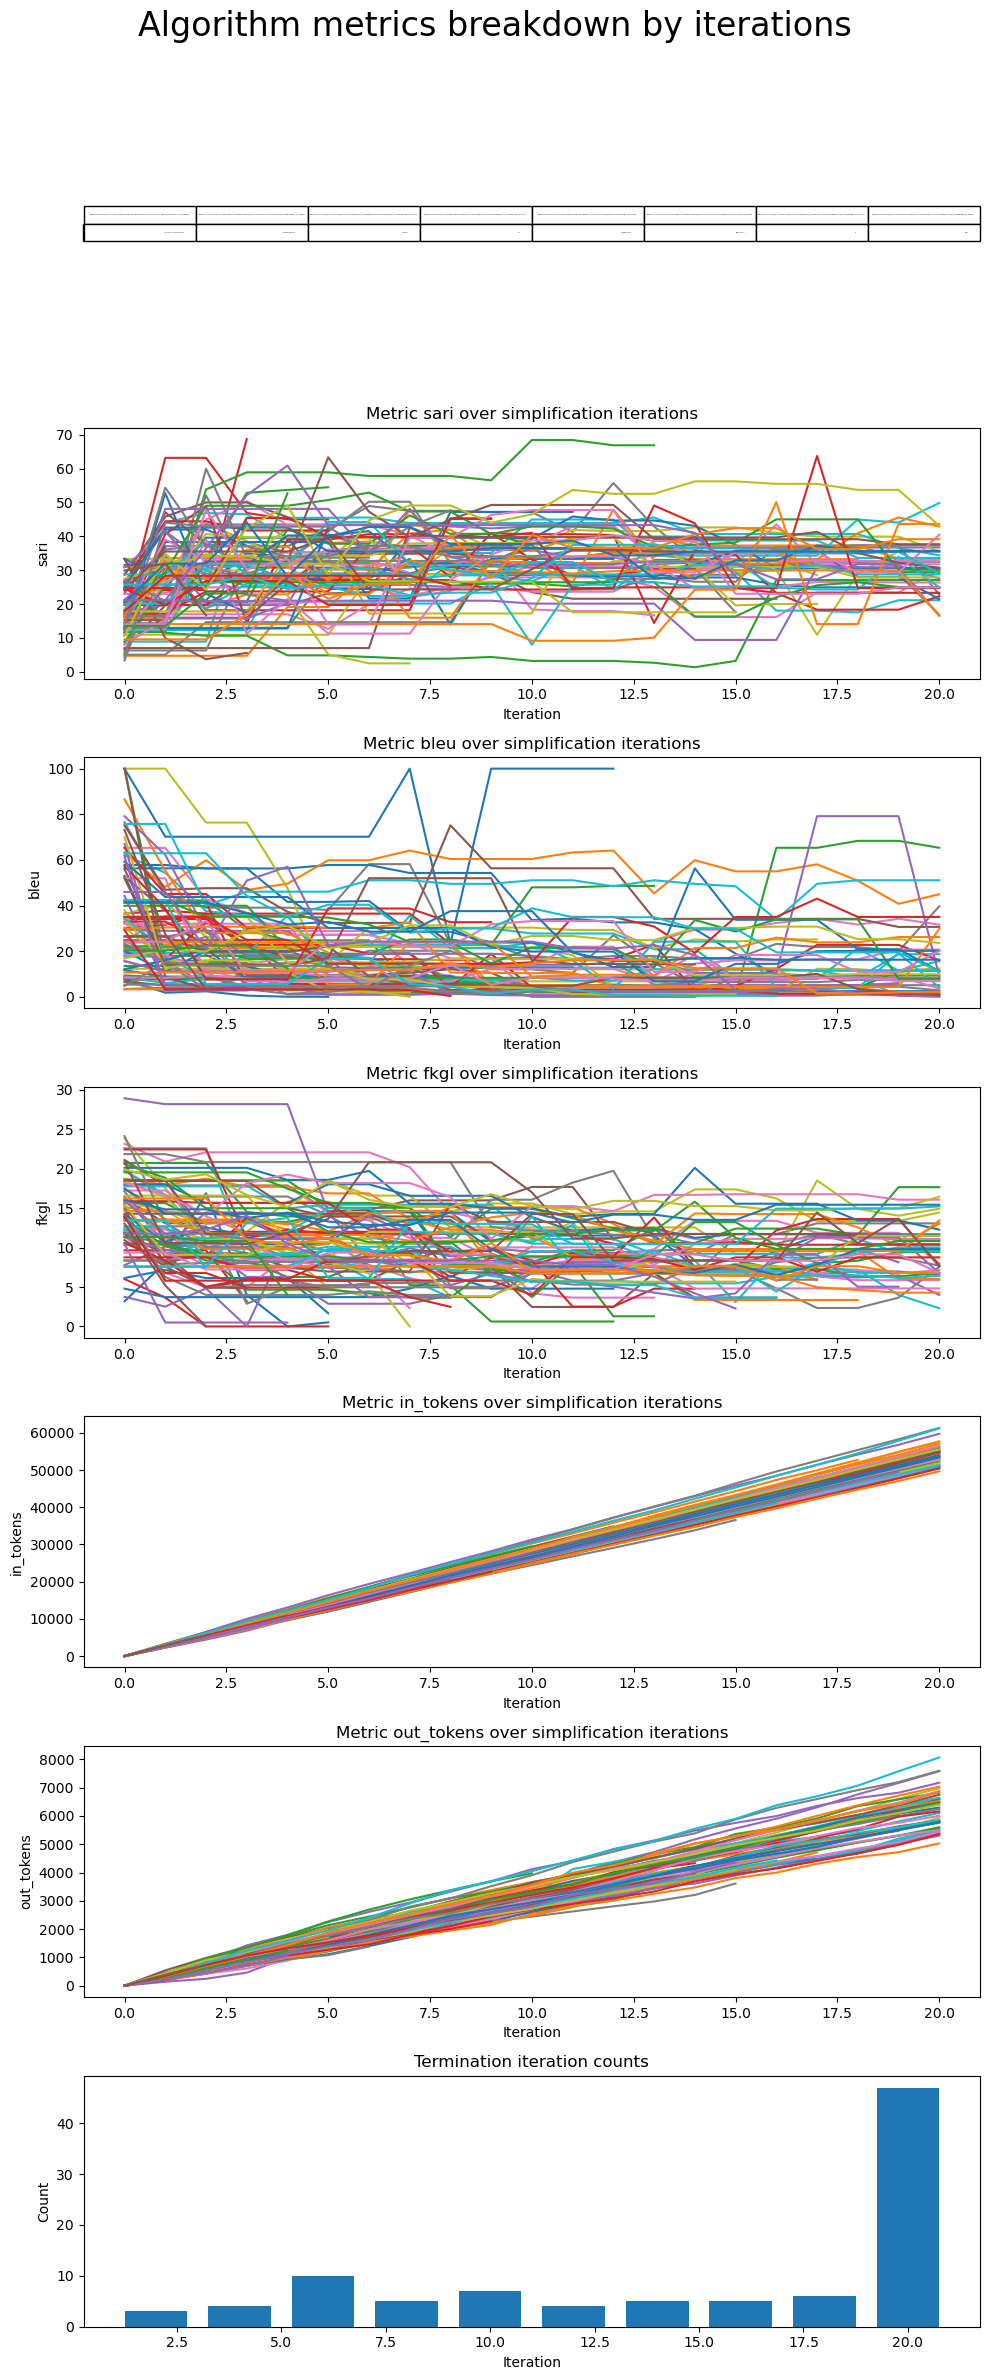

<Figure size 640x480 with 0 Axes>

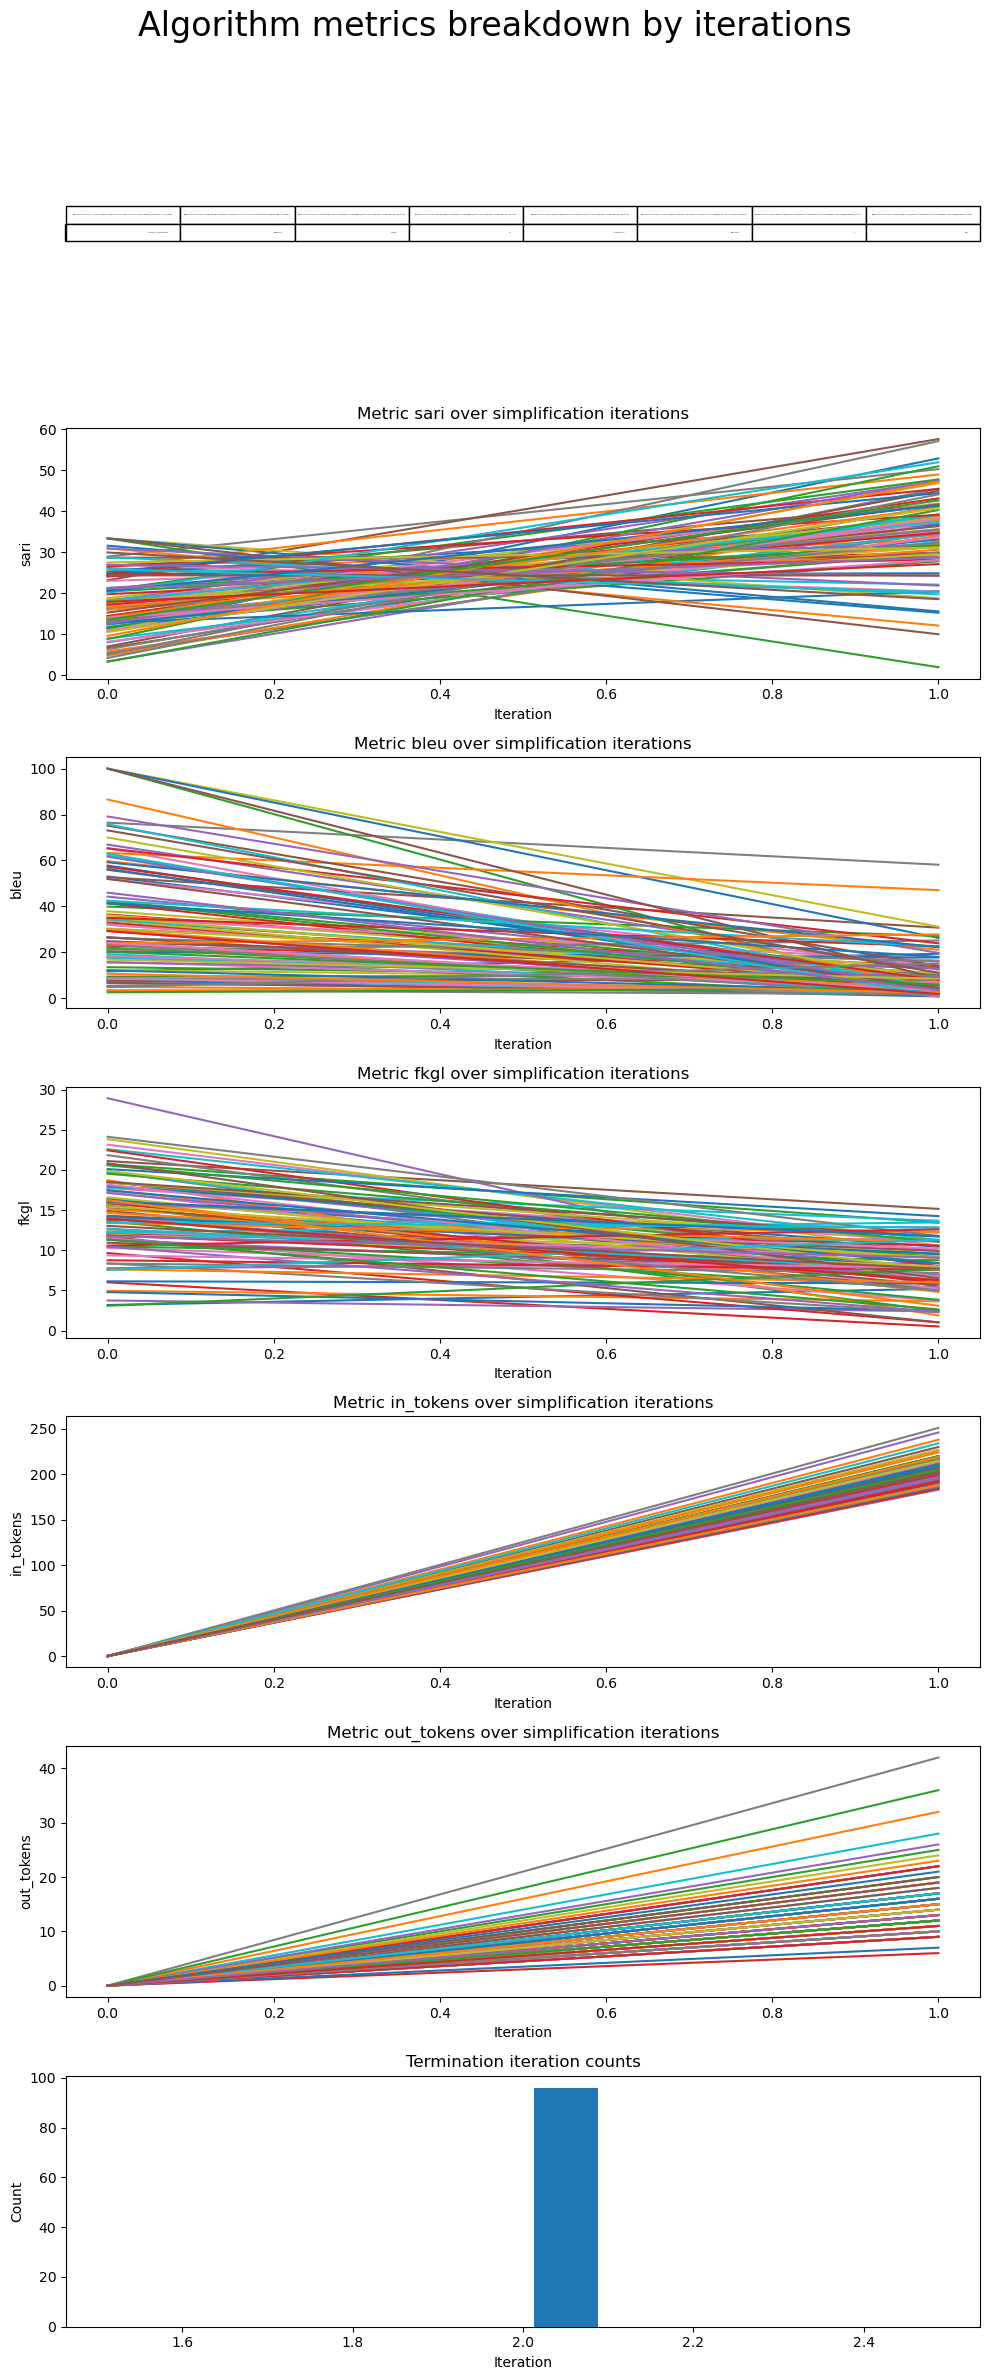

<Figure size 640x480 with 0 Axes>

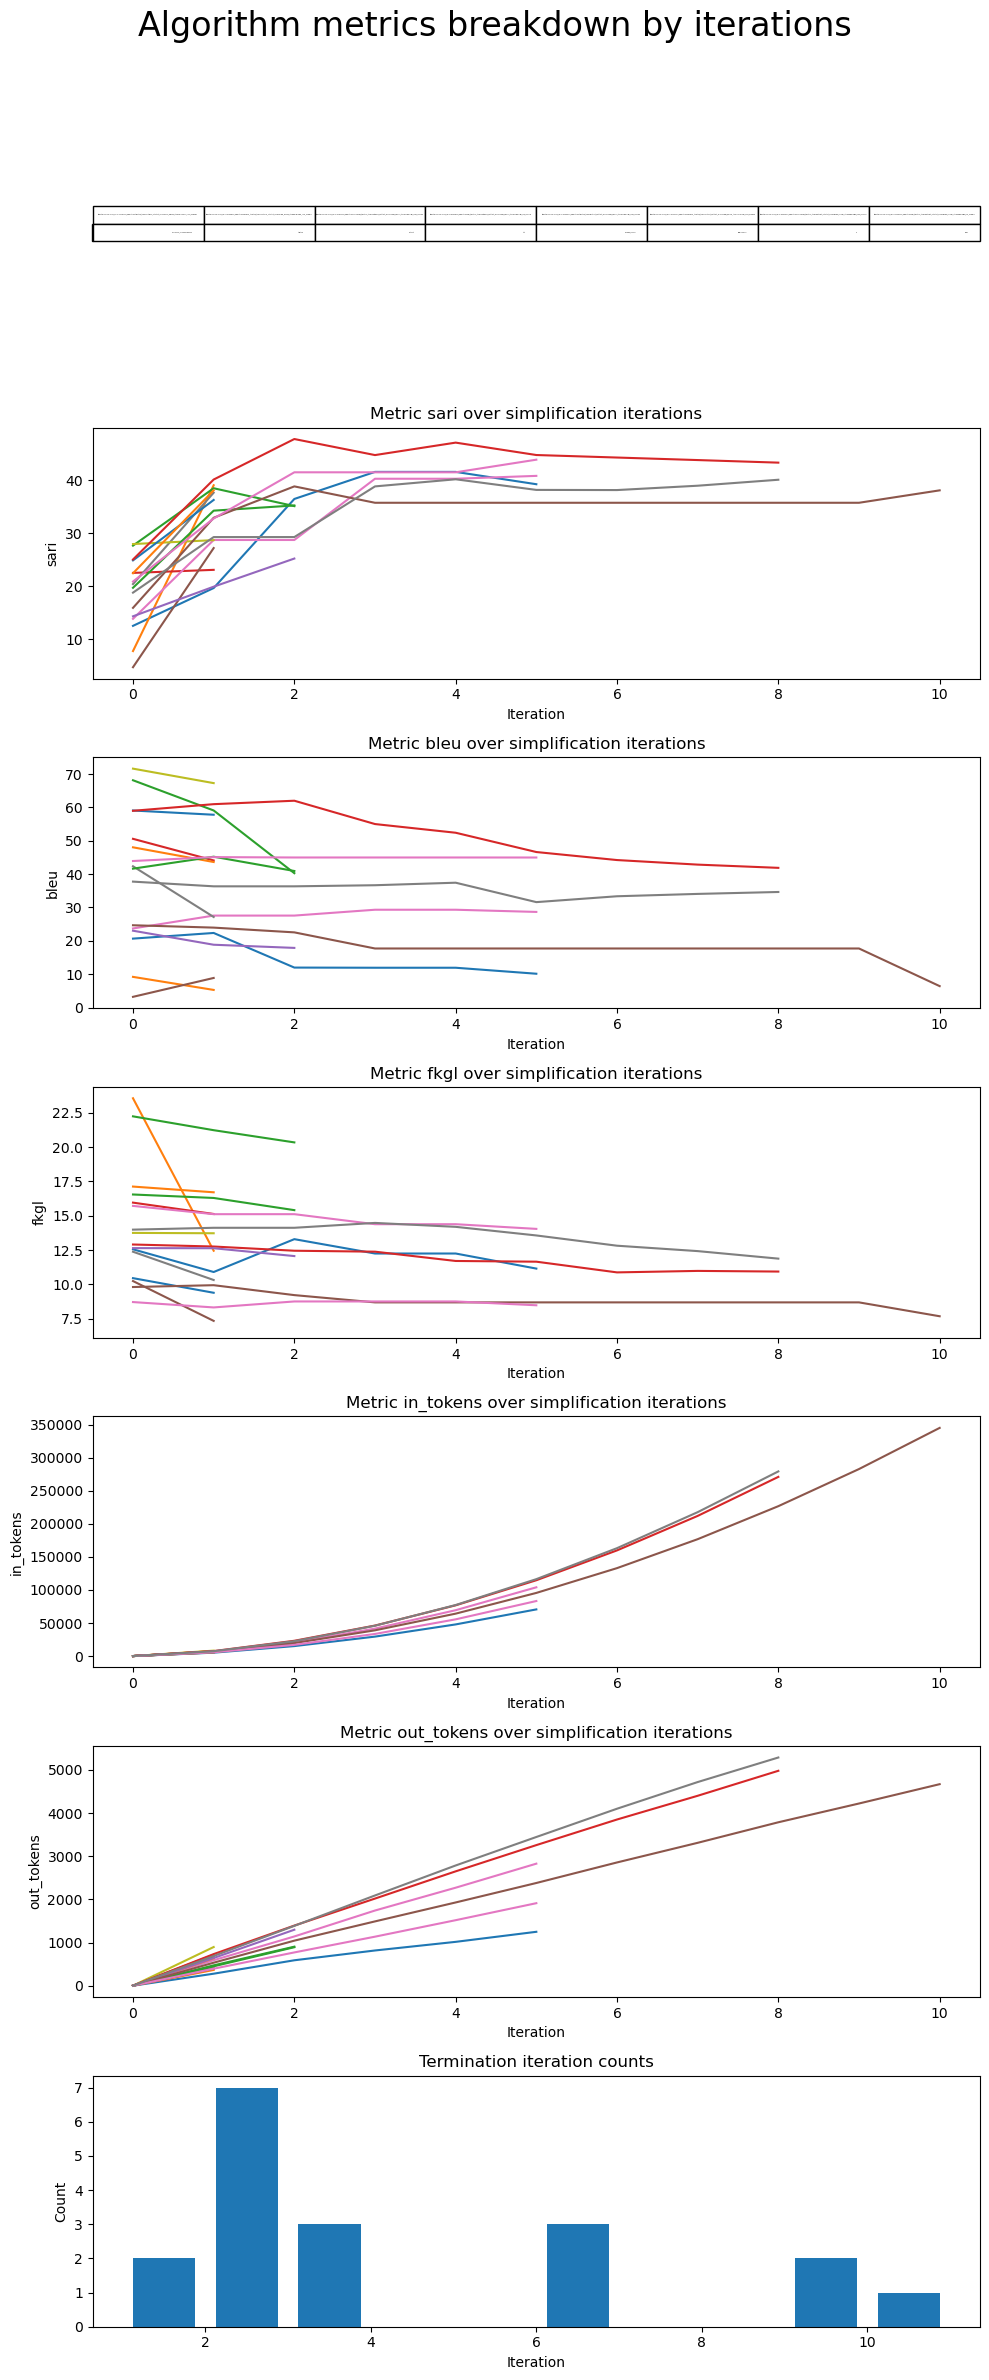

<Figure size 640x480 with 0 Axes>

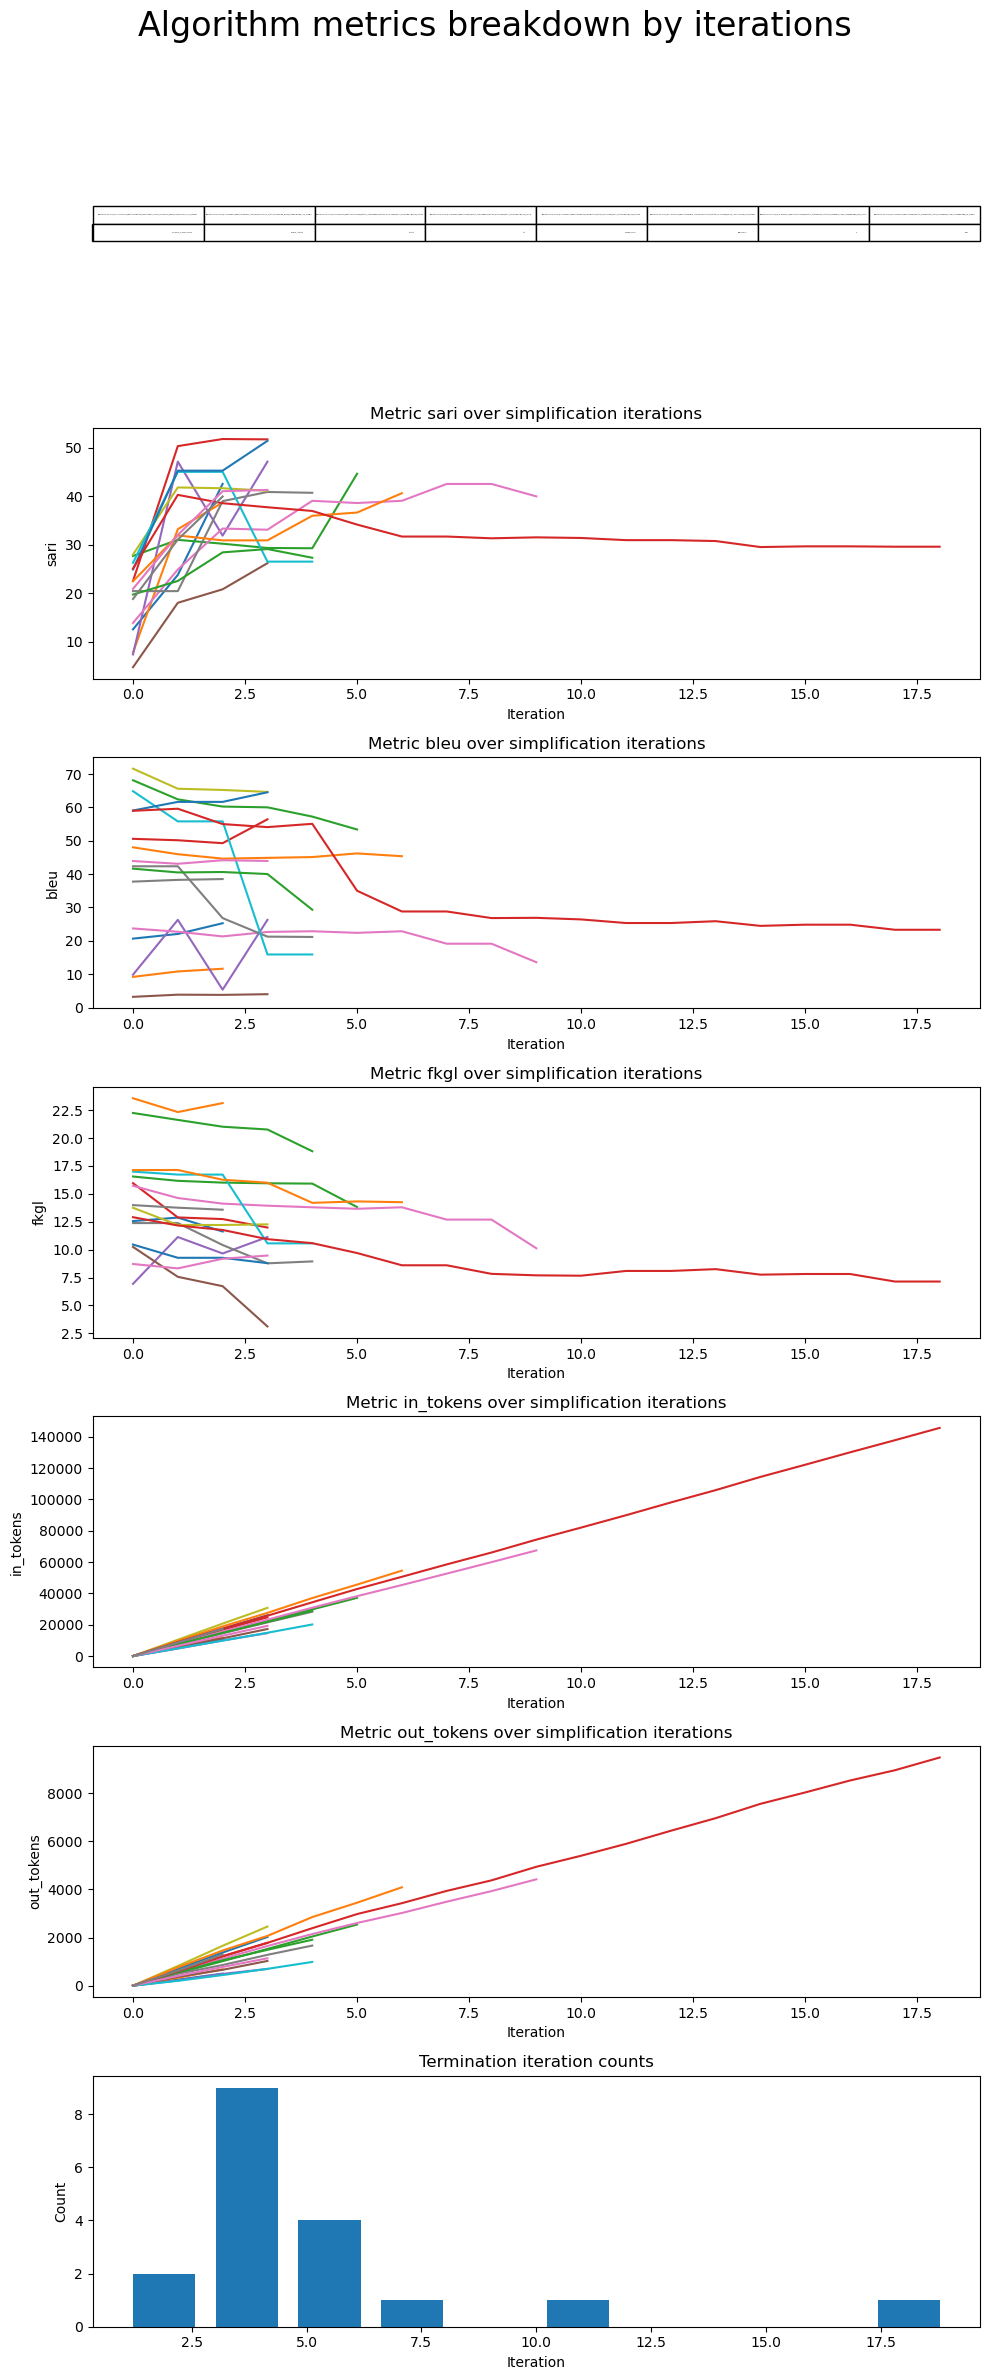

<Figure size 640x480 with 0 Axes>

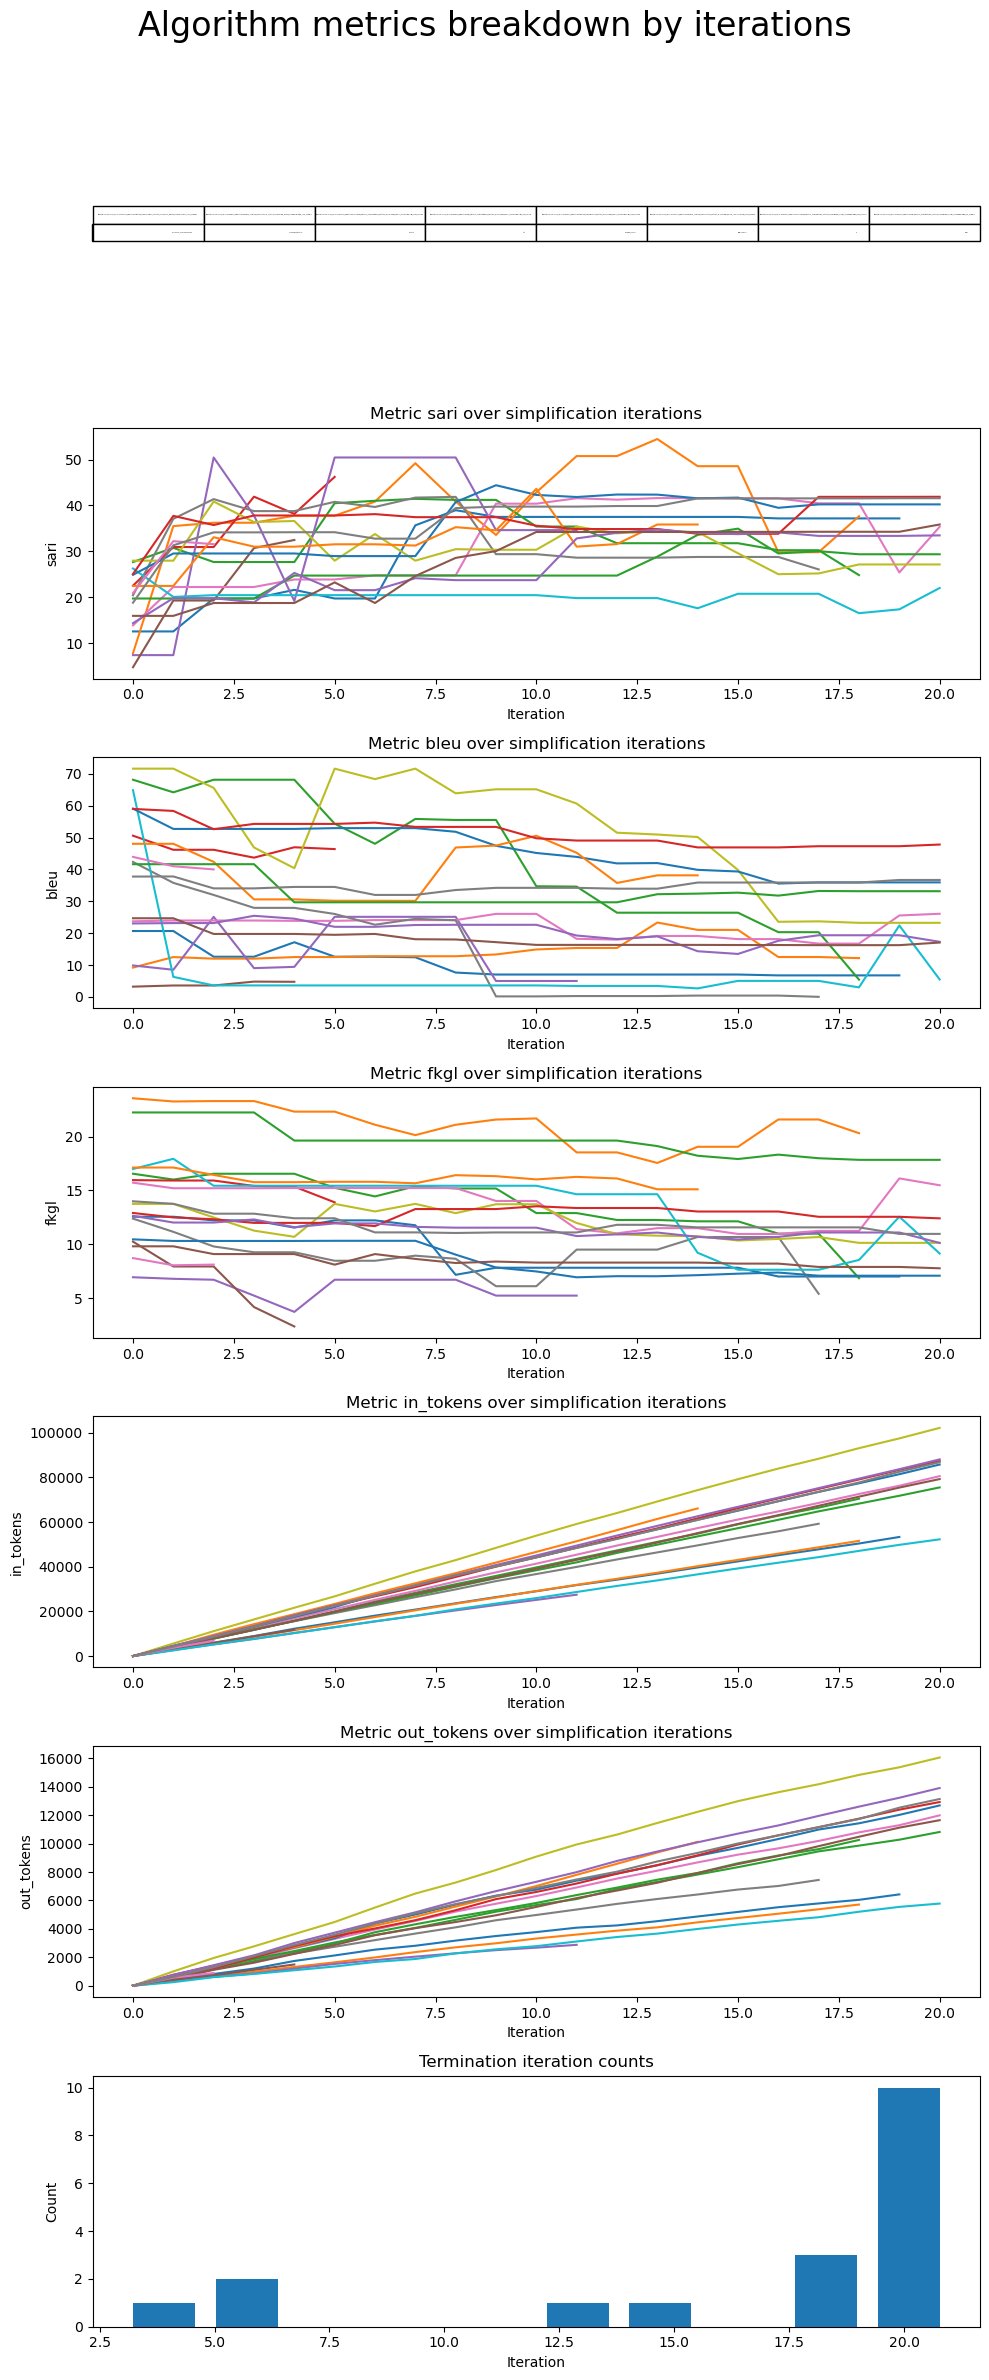

<Figure size 640x480 with 0 Axes>

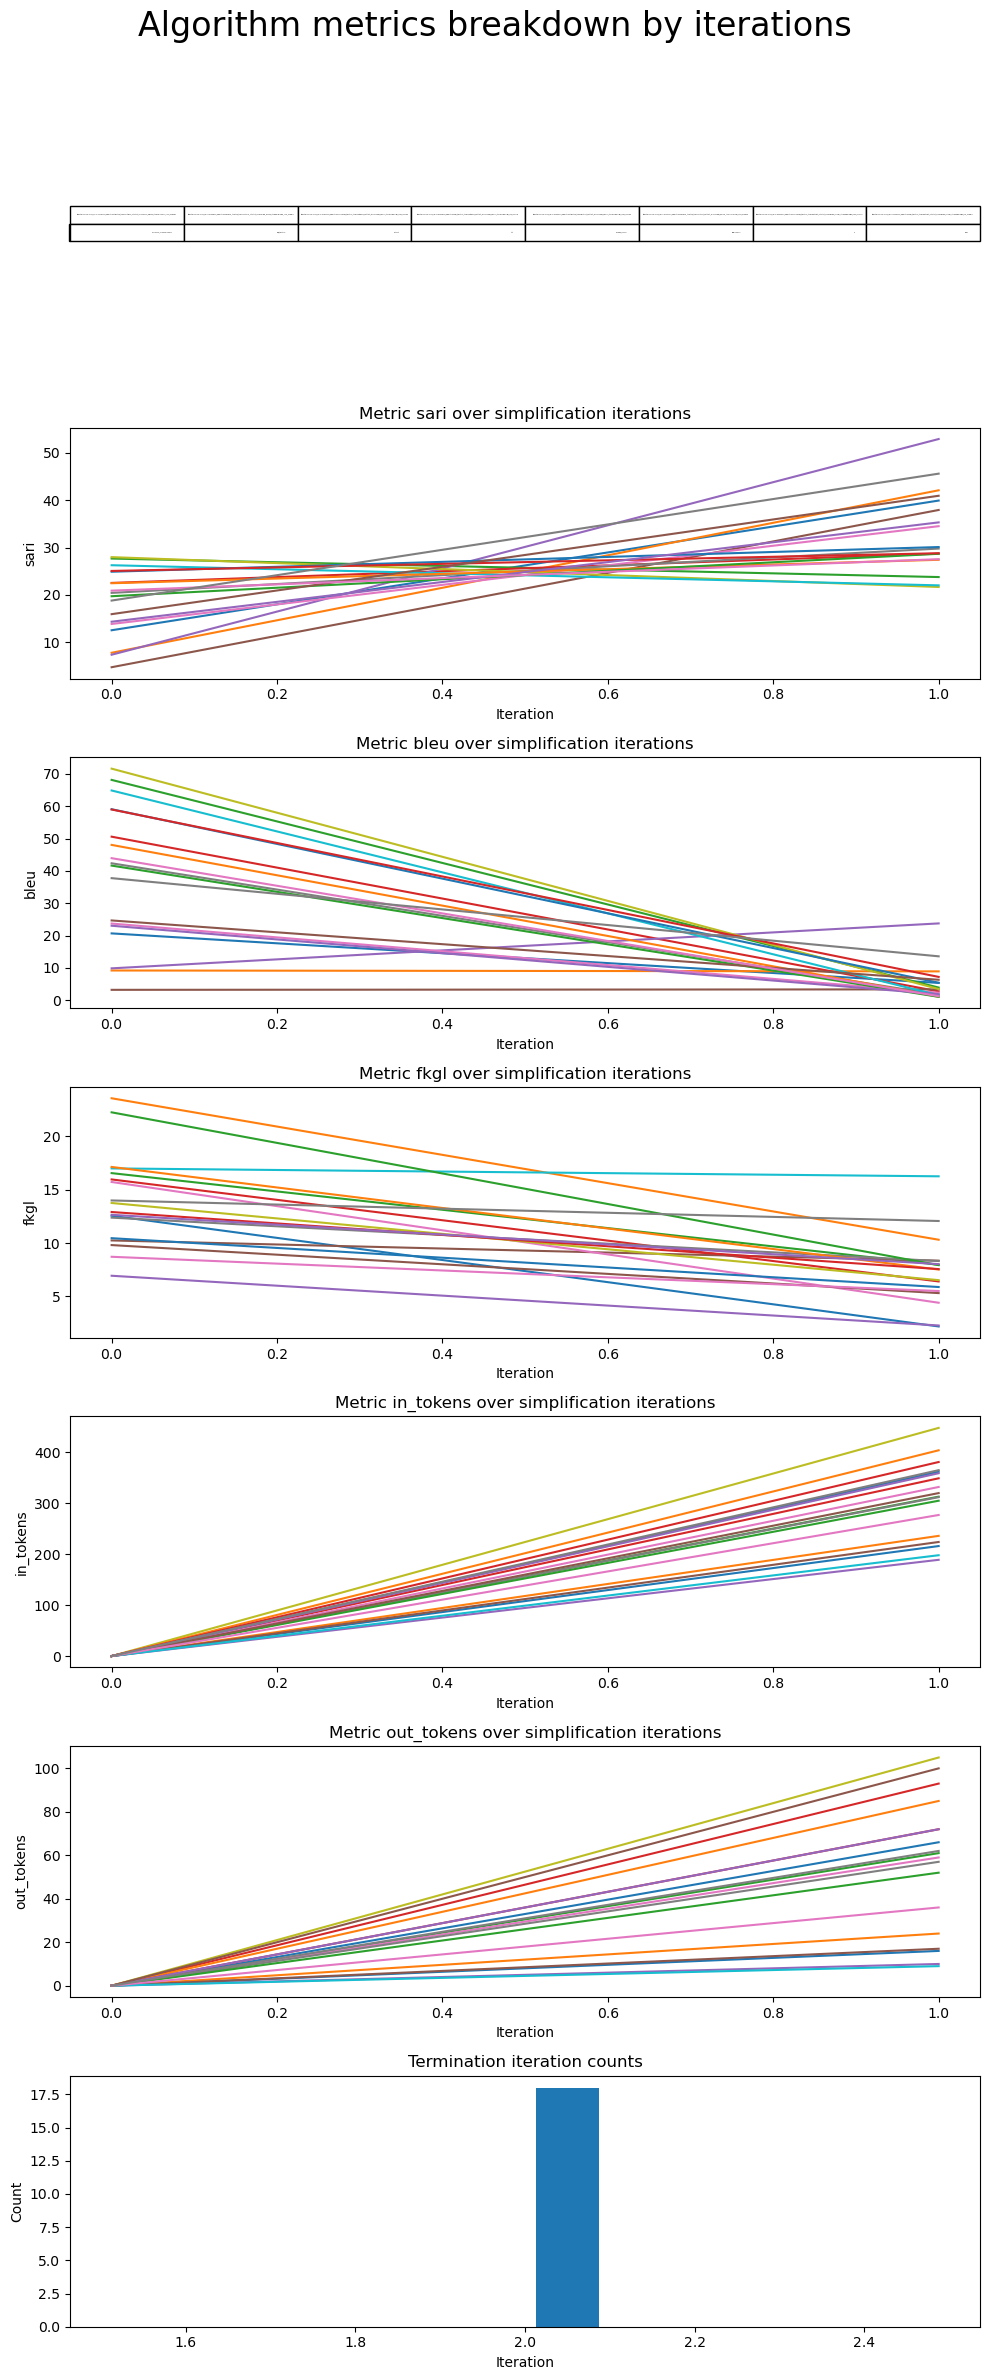

In [7]:
for run_name in latest_run_names:
    file_name = f"evaluations/metrics/{run_name}.json"
    with open(file_name, encoding="utf8") as file:
        contents = json.load(file)
        metric_names = contents[0][0]["metrics"].keys()
        metric_count = len(metric_names)

        # fig, axes = plt.subplots(metric_count, 1, figsize=(10, 4 * metric_count), sharex=True)
        fig, axes = plt.subplots(metric_count + 2, 1, figsize=(10, 5 * metric_count)) # + 1 is for the table of parameters above the plots
        fig.suptitle(f"Algorithm metrics breakdown by iterations", fontsize=24)
        if metric_count == 1:
            axes = [axes]

        ### Showing the parameter table
        parameter_df = extract_parameters_from_file_names(parameter_names=latest_run_names, file_names=[run_name])
        # pd.plotting.table(axes, parameter_df, loc='bottom') 
        table_axis = axes[0]
        table_axis.axis("off")
        pd.plotting.table(table_axis, parameter_df, loc='center')

        ### Plotting each iteration
        iteration_counts = []

        for metric_name_index, metric_name in enumerate(metric_names):
            axes[metric_name_index + 1].set_title(f"Metric {metric_name} over simplification iterations")
            axes[metric_name_index + 1].set_xlabel("Iteration")
            axes[metric_name_index + 1].set_ylabel(f"{metric_name}")
        
        for object_index, passage_data in enumerate(contents):
            metrics_series = {metric_name: [] for metric_name in metric_names}
            
            iteration_count = len(passage_data) ######################################## USE THIS TO GRAPH THE HISTOGRAM OF ITERATION COUNTS
            iteration_indices = list(range(iteration_count))
            iteration_counts.append(iteration_count)

            for iteration_data in passage_data:
                for metric_name, metric_value in iteration_data["metrics"].items():
                    metrics_series[metric_name].append(metric_value)

            for metric_index, (metric_name, metric_series) in enumerate(metrics_series.items()):
                axes[metric_index + 1].plot(iteration_indices, metric_series, label=f"Passage no {object_index}")

        ### Plotting the histogram of iteration termination
        axes[-1].hist(iteration_counts, rwidth=0.75) # align="left",
        axes[-1].set_title("Termination iteration counts")
        axes[-1].set_xlabel("Iteration")
        axes[-1].set_ylabel("Count")

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(f"graphs/iterations/{run_name}.png")
        plt.show()

        plt.clf()
plt.close()

#### Iteration graphs – FKGL vs SARI

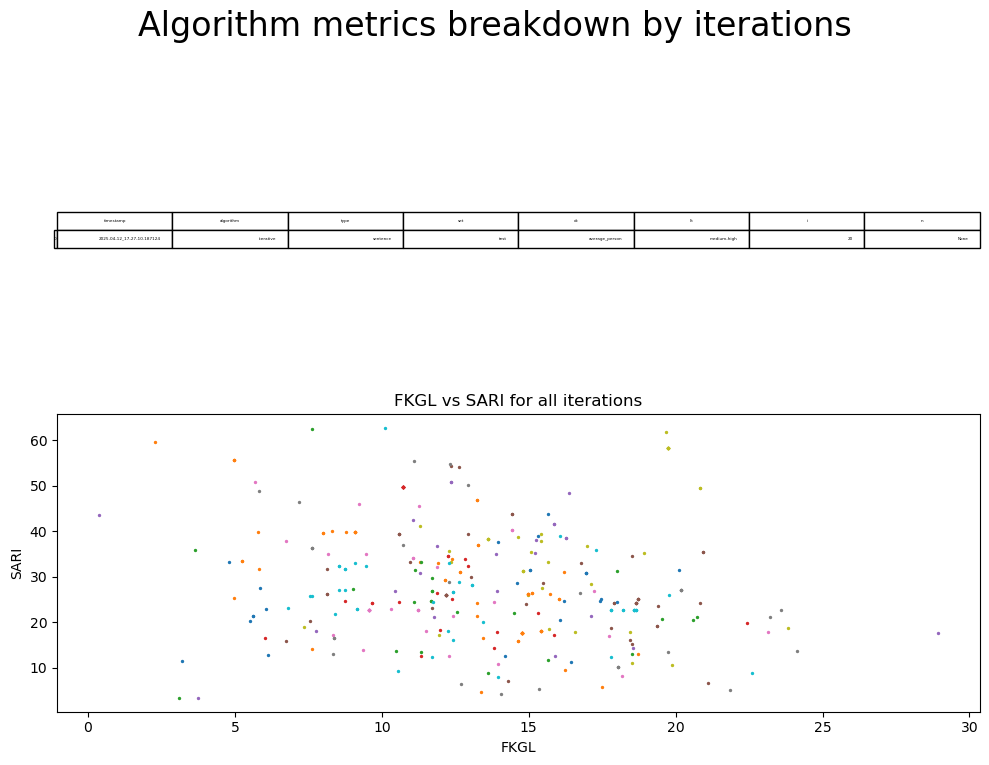

<Figure size 640x480 with 0 Axes>

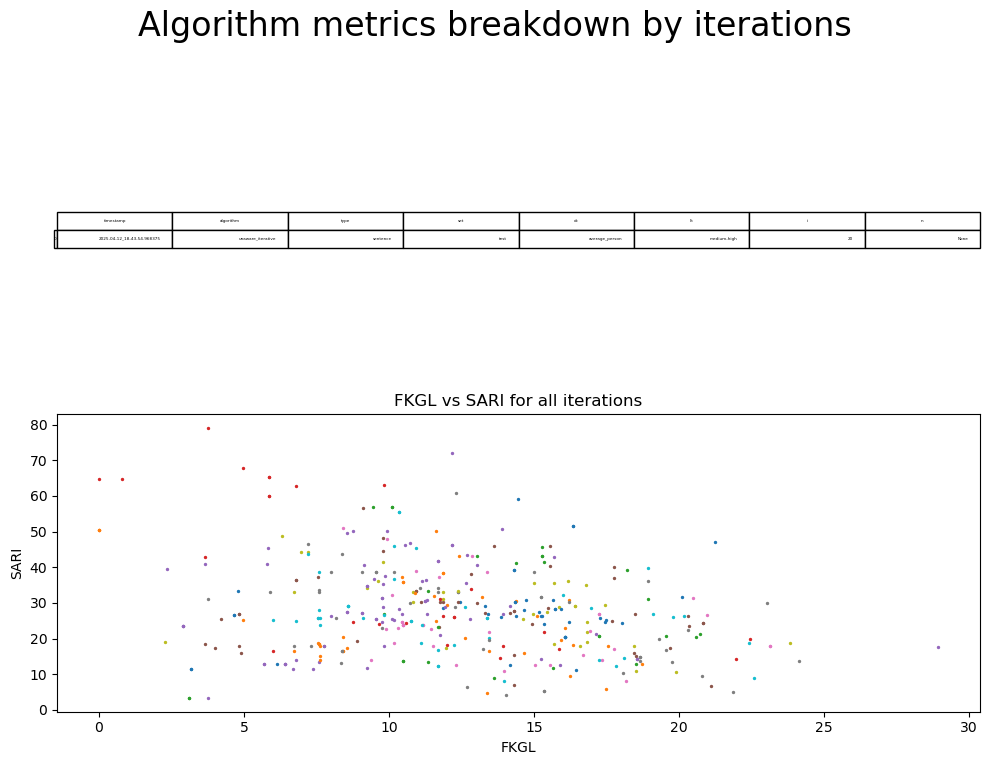

<Figure size 640x480 with 0 Axes>

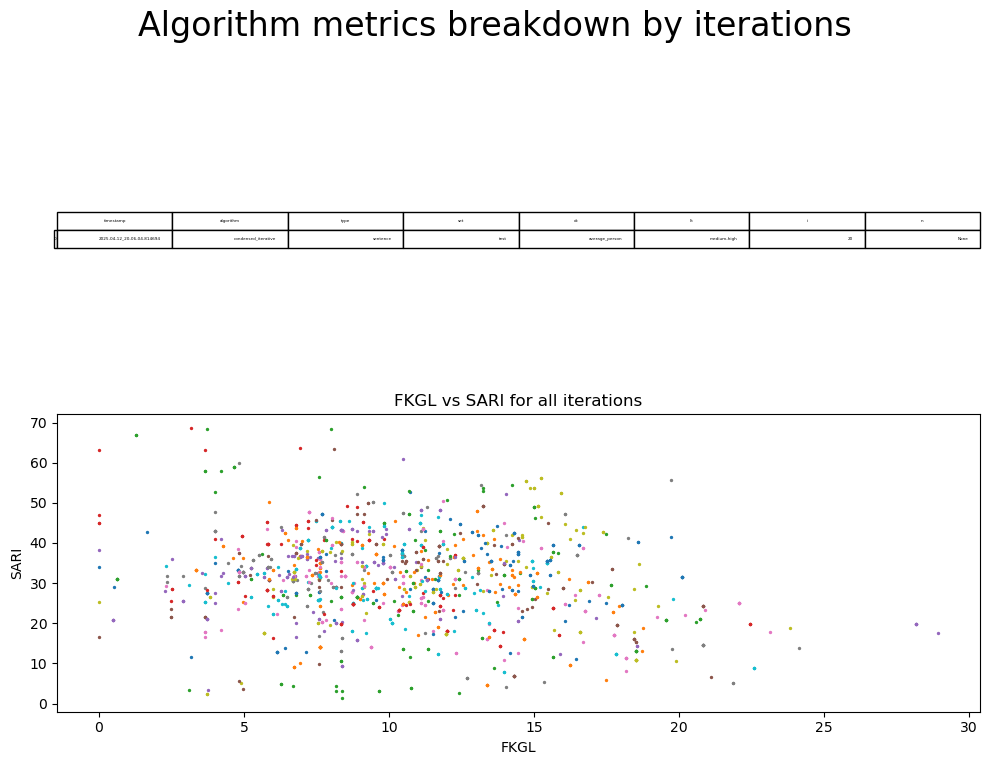

<Figure size 640x480 with 0 Axes>

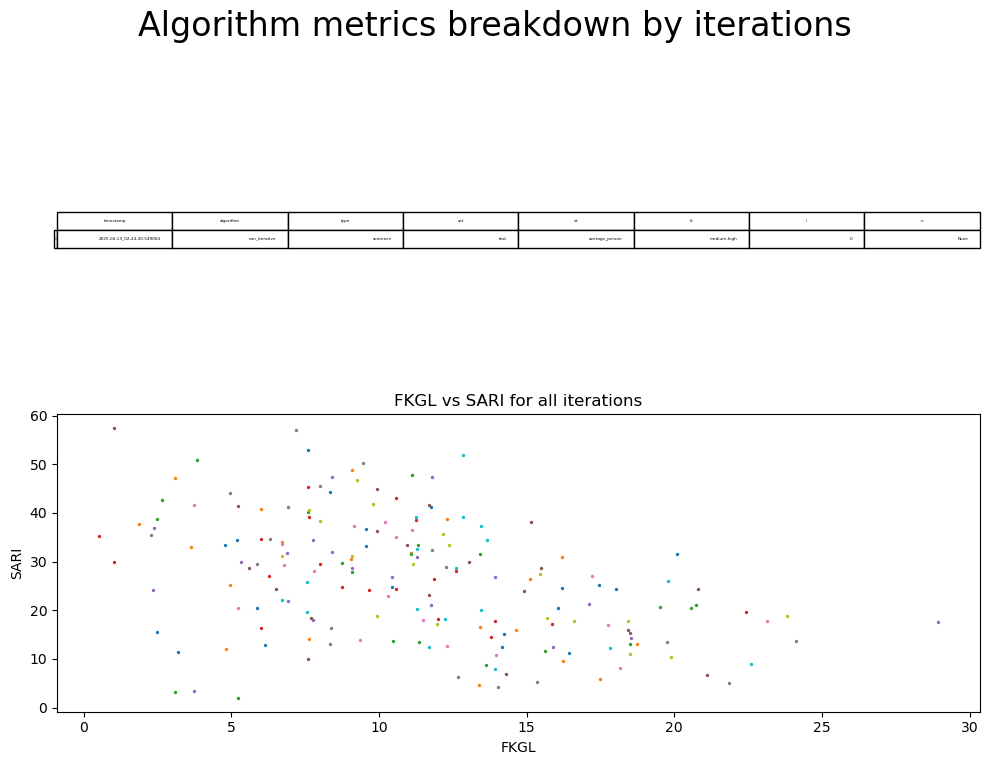

<Figure size 640x480 with 0 Axes>

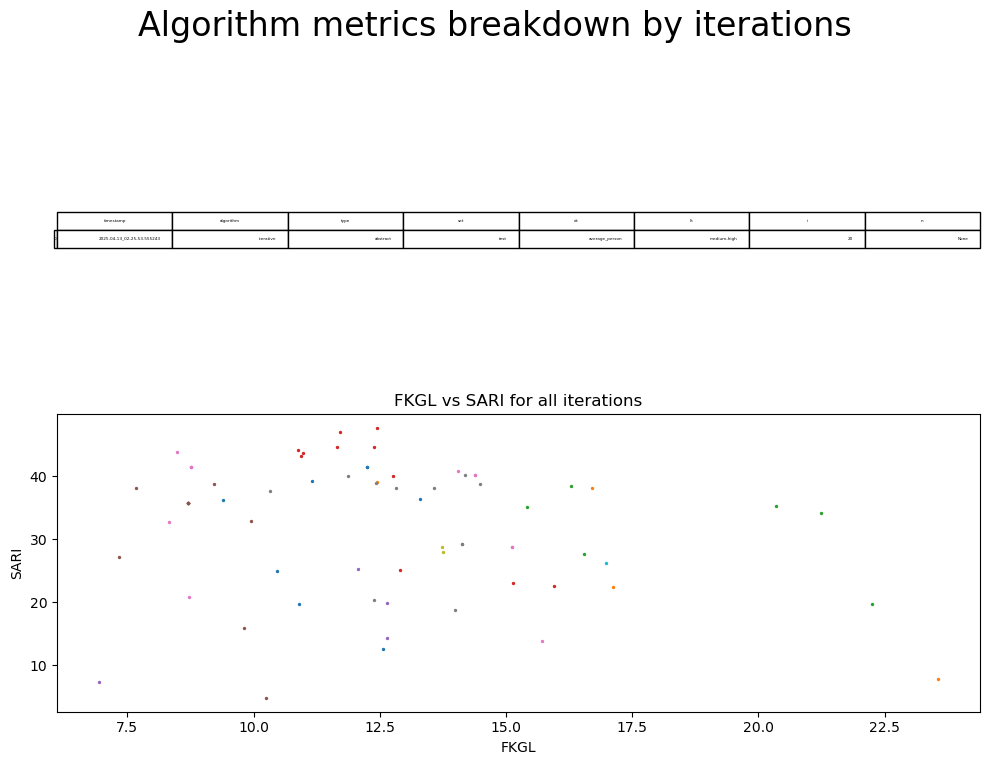

<Figure size 640x480 with 0 Axes>

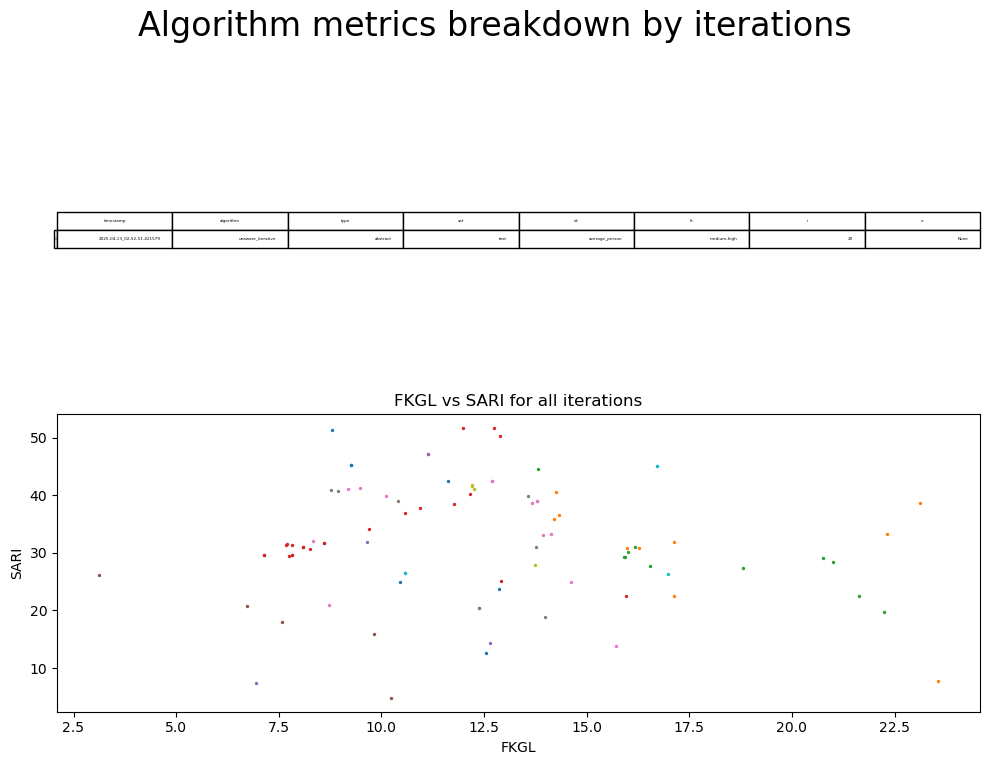

<Figure size 640x480 with 0 Axes>

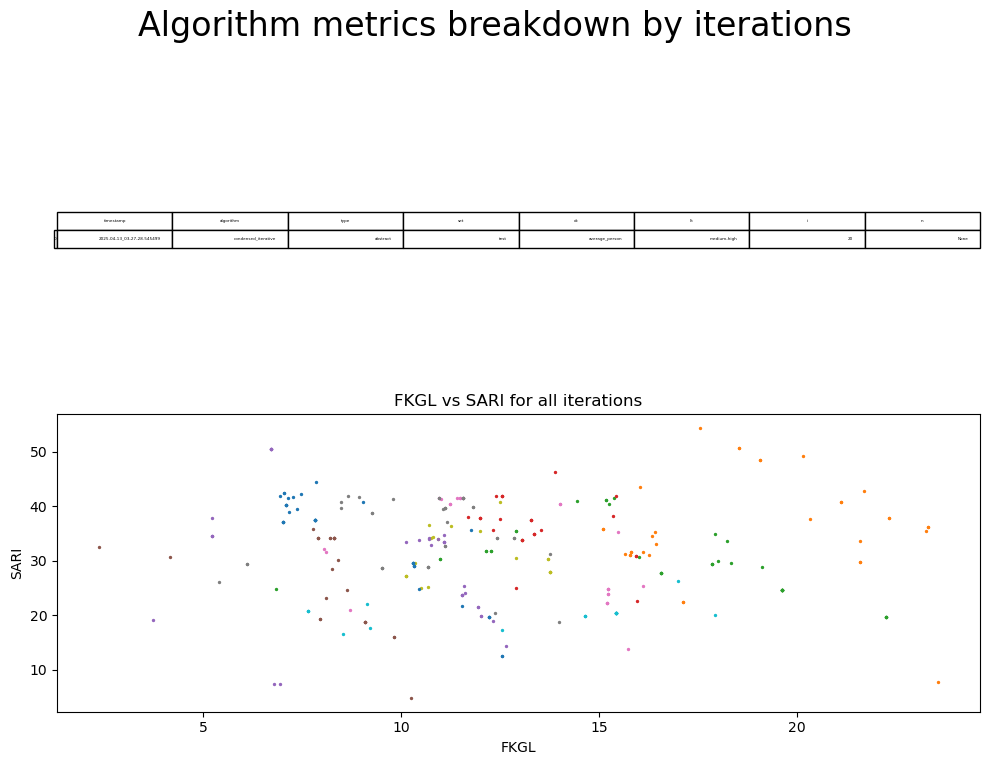

<Figure size 640x480 with 0 Axes>

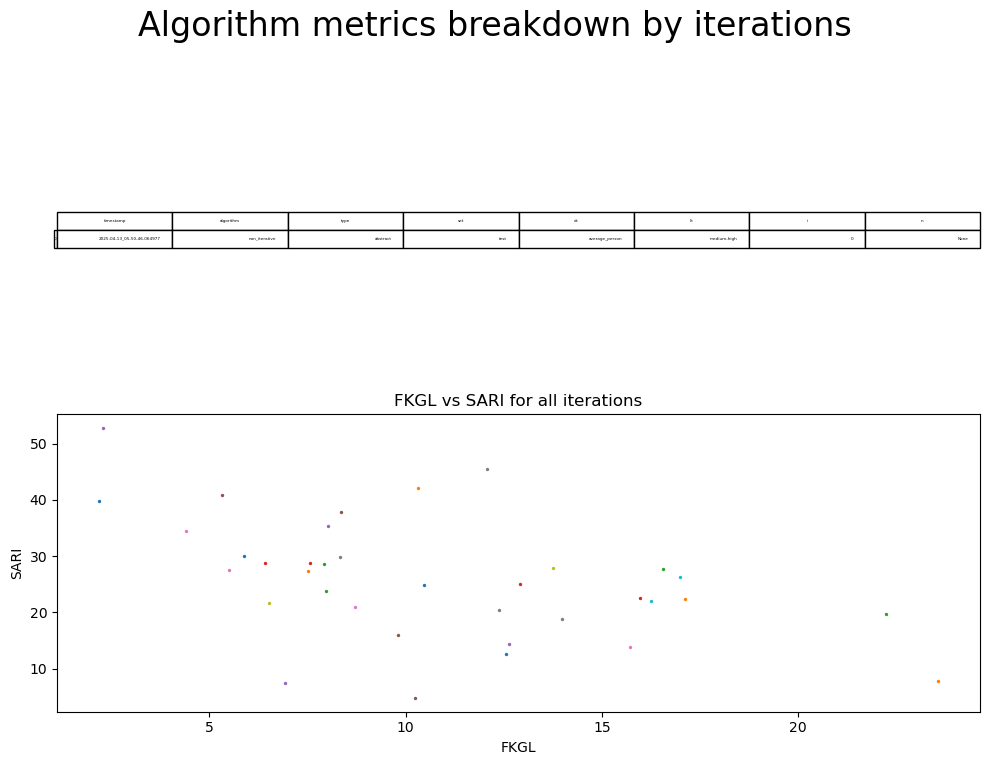

In [8]:
for run_name in latest_run_names:
    file_name = f"evaluations/metrics/{run_name}.json"
    with open(file_name, encoding="utf8") as file:
        contents = json.load(file)
        metric_names = contents[0][0]["metrics"].keys()

        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        fig.suptitle(f"Algorithm metrics breakdown by iterations", fontsize=24)

        ### Showing the parameter table
        parameter_df = extract_parameters_from_file_names(parameter_names=parameter_names, file_names=[run_name])
        # pd.plotting.table(axes, parameter_df, loc='bottom') 
        table_axis = axes[0]
        table_axis.axis("off")
        pd.plotting.table(table_axis, parameter_df, loc='center')

        ### Plotting each iteration
        iteration_counts = []
        
        for object_index, passage_data in enumerate(contents):
            metrics_series = {metric_name: [] for metric_name in metric_names}

            for iteration_data in passage_data:
                for metric_name, metric_value in iteration_data["metrics"].items():
                    metrics_series[metric_name].append(metric_value)

            axes[1].scatter(metrics_series["fkgl"], metrics_series["sari"], s=2) # label=f"Passage no {object_index}"
            axes[1].set_title("FKGL vs SARI for all iterations")
            axes[1].set_xlabel("FKGL")
            axes[1].set_ylabel("SARI")

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(f"graphs/iterations/{run_name}_scatter.png")
        plt.show()

        plt.clf()
plt.close()

#### Iteration graphs – iteration as corpus

In [ ]:
metric_names = ["sari", "bleu", "fkgl"]
metric_count = len(metric_names)

fig, axes = plt.subplots(metric_count + 1, 1, figsize=(10, 5 * metric_count)) # + 1 is for the table of parameters above the plots
fig.suptitle(f"Algorithm metrics breakdown by iterations", fontsize=24)

### Showing the parameter table
parameter_df = extract_parameters_from_file_names(parameter_names=parameter_names, file_names=latest_run_names)
trimmed_parameter_df, dropped_columns = drop_single_value_columns(parameter_df)
# pd.plotting.table(axes, parameter_df, loc='bottom') 
table_axis = axes[0]
table_axis.axis("off")
pd.plotting.table(table_axis, parameter_df, loc='center')

for file_index, run_name in enumerate(latest_run_names):
    file_name = f"evaluations/metrics/{run_name}.json"
    with open(file_name, encoding="utf8") as file:
        contents = json.load(file)
        # display(trimmed_parameter_df.iloc[file_index])
        trimmed_file_name = convert_row_to_name(trimmed_parameter_df.iloc[file_index], ignored_columns=["timestamp", "i"])

        passage_type = parameter_df.iloc[file_index]["type"]
        max_iter = int(parameter_df.iloc[file_index]["i"])
        passage_count = parameter_df.iloc[file_index]["n"]
        passage_count = None if passage_count == "None" else int(passage_count)

        iteration_indices = list(range(max_iter + 1))

        data_type = re.search(r"_set=(train|test)_", run_name).groups(1)[0]

        if passage_type == "abstract":
            sources, references = dataset_utils.get_sources_and_references("abs", data_type, passage_count)
        elif passage_type == "sentence":
            sources, references = dataset_utils.get_sources_and_references("snt", data_type, passage_count)

        metrics_series = {metric_name: [] for metric_name in metric_names}

        ### Plotting each iteration
        for iteration in range(max_iter + 1):
            iteration_predictions = []

            for passage_simplifications in contents:
                current_or_last_index = min(iteration, len(passage_simplifications) - 1)
                iteration_predictions.append(passage_simplifications[current_or_last_index]["prediction"])

            metrics_series["sari"].append(easse.sari.corpus_sari(sys_sents=iteration_predictions, refs_sents=[references], orig_sents=sources))
            metrics_series["bleu"].append(easse.bleu.corpus_bleu(sys_sents=iteration_predictions, refs_sents=[references]))
            metrics_series["fkgl"].append(easse.fkgl.corpus_fkgl(sentences=iteration_predictions))

        for metric_index, (metric_name, metric_series) in enumerate(metrics_series.items()):
            axes[metric_index + 1].plot(iteration_indices, metric_series, label=f"{file_index}: {trimmed_file_name}")
            # axes[metric_index + 1].plot(iteration_indices, iteration_indices, label=f"{file_index}: {trimmed_file_name}")


for metric_name_index, metric_name in enumerate(metric_names):
    axes[metric_name_index + 1].set_title(f"Metric {metric_name} over simplification iterations")
    axes[metric_name_index + 1].set_xlabel("Iteration")
    axes[metric_name_index + 1].set_ylabel(f"{metric_name}")
    axes[metric_name_index + 1].legend(loc="best", fontsize=5)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig(f"graphs/{timestamp}_all_algs.png")
plt.show()

plt.clf()
plt.close()

## Info Loss & Hallucinations

#### Info units

In [ ]:
# Based on code generated by ChatGPT
def calculate_information_pseudo_percentages(run_names):
    pseudo_percentages = {}

    parameter_df = extract_parameters_from_file_names(parameter_names=parameter_names, file_names=run_names)
    trimmed_parameter_df, dropped_columns = drop_single_value_columns(parameter_df)

    for run_index, run_name in enumerate(run_names):
        trimmed_run_name = convert_row_to_name(trimmed_parameter_df.iloc[run_index], ignored_columns=["timestamp", "i"])

        with open(f"evaluations/information_comparison/{run_name}.json", "r", encoding="utf-8") as file:
            comparisons = json.load(file)

        percentages = []
        for comparison in comparisons:
            ### INVESTIGATE HERE – MISSING  OVERSIMPLIFICATIONS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # P = len(comparison["comparison"]["preservations"])
            # O = len(comparison["comparison"]["oversimplifications"])
            # D = len(comparison["comparison"]["deletions"])
            # H = len(comparison["comparison"]["hallucinations"])
            P = len(comparison["comparison"].get("preservations", []))
            O = len(comparison["comparison"].get("oversimplifications", []))
            D = len(comparison["comparison"].get("deletions", []))
            H = len(comparison["comparison"].get("hallucinations", []))

            source_cardinality = P + O + D
            if source_cardinality == 0:
                continue

            P_percentage = P / source_cardinality
            O_percentage = O / source_cardinality
            D_percentage = D / source_cardinality
            H_percentage = H / source_cardinality
            percentages.append((P_percentage, O_percentage, D_percentage, H_percentage))

        pseudo_percentages[trimmed_run_name] = percentages

    return pseudo_percentages

# Based on code generated by ChatGPT
def graph_information_pseudo_percentages(pseudo_percentages):
    labels = []
    mean_percentages = []

    for run_name, tuples in pseudo_percentages.items():
        if not tuples:
            continue
        labels.append(run_name)
        avg = np.mean(tuples, axis=0)
        mean_percentages.append(avg)

    mean_percentages = np.array(mean_percentages)
    P_vals = mean_percentages[:, 0]
    O_vals = mean_percentages[:, 1]
    D_vals = mean_percentages[:, 2]
    H_vals = mean_percentages[:, 3]

    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x, P_vals, label="Preservations", color="green")
    ax.bar(x, O_vals, bottom=P_vals, label="Oversimplifications", color="orange")
    ax.bar(x, D_vals, bottom=P_vals + O_vals, label="Deletions", color="red")
    ax.bar(x, -H_vals, label="Hallucinations", color="blue")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.axhline(0, color="black", linewidth=1)
    ax.set_ylabel("% of source information")
    ax.set_title("Mean Information Retention per Algorithm")
    ax.legend()

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S.%f")
    plt.savefig(f"graphs/{timestamp}_information_retention.png")

    plt.tight_layout()
    plt.show()

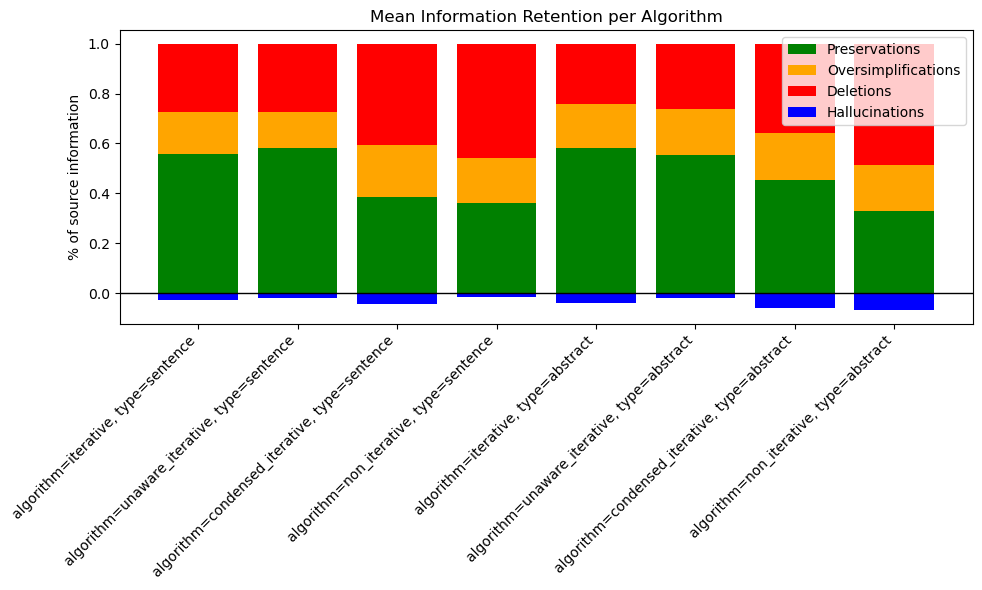

In [14]:
information_pseudo_percentages = calculate_information_pseudo_percentages(latest_run_names)
graph_information_pseudo_percentages(information_pseudo_percentages)